In [135]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# import OpenCV
import cv2

In [136]:
template_color = cv2.imread('../Data/28_AP_0.14.tif') # Read template image
template_color = cv2.cvtColor(template_color, cv2.COLOR_BGR2RGB) # Convert to RGB
template = cv2.cvtColor(template_color, cv2.COLOR_BGR2GRAY) # Color to Grayscale

In [137]:
# Image plotting function
def plot_image(image, gray=True):
    plt.figure(figsize=(10,7))
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.grid('off')
    plt.show()

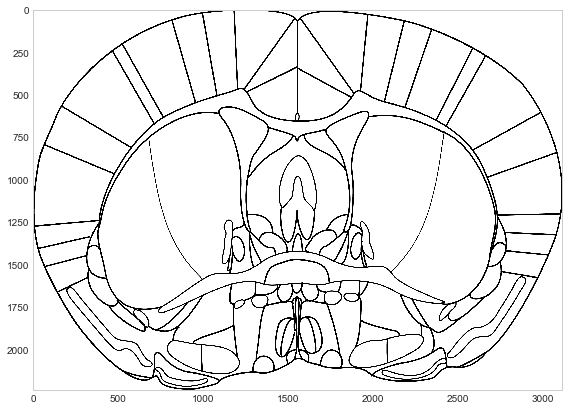

In [138]:
# Plot template image
plot_image(template)

In [139]:
# Invert template color to highlight the edges
template_inv = cv2.bitwise_not(template)

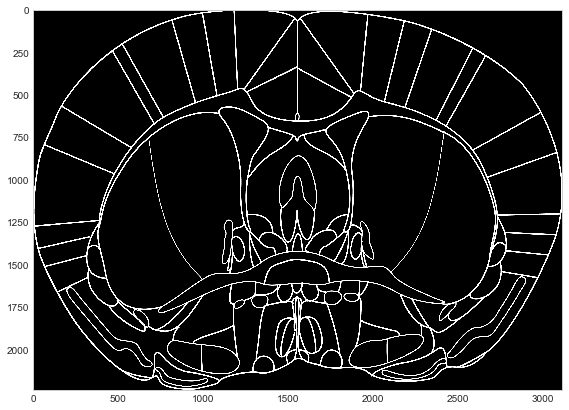

In [140]:
plot_image(template_inv)

In [141]:
img_color = cv2.imread('../Data/20170914_D2CreAi14_M527_G_RB_pDMS_S1P2_R1C3_001.tif') # Read base image
img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB) # Convert BGR (OpenCV) to RGB (matplotlib) for plotting
img = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY) # Convert to grayscale

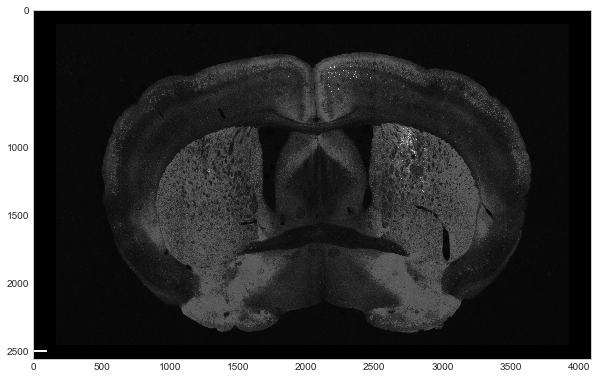

In [142]:
# Plot base image
plot_image(img)

In [143]:
# Reduce image size (downsample) for 
height, width = img.shape
img_down = cv2.resize(img,(int(0.1*width), int(0.1*height)), interpolation = cv2.INTER_AREA)

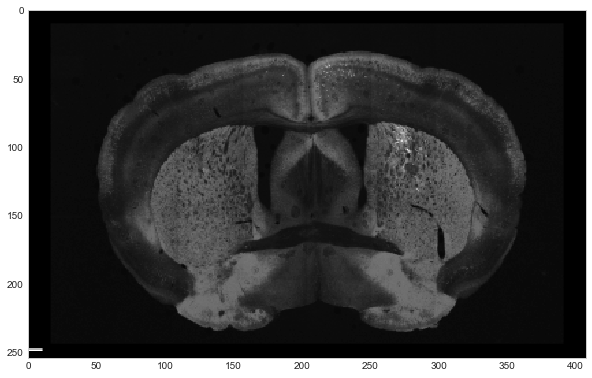

In [144]:
# Plot shrinked image
plot_image(img_down)

## Edge detection

In [185]:
# Morphological transforms for filling empty spaces in stained image
kernel = np.ones((3,3),np.uint8)
# img_down = cv2.bilateralFilter(img_down,9,17,17)
img_down = cv2.dilate(img_down, kernel, iterations = 2)
img_down = cv2.erode(img_down, kernel, iterations = 2)

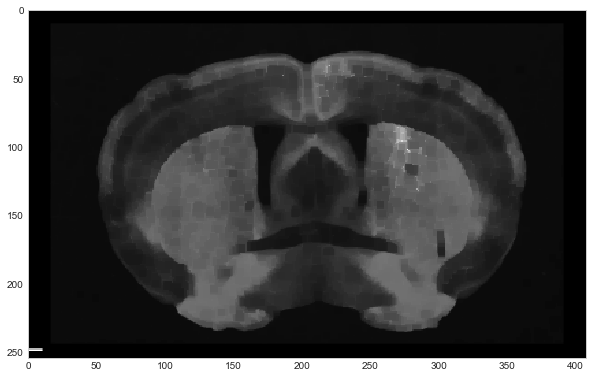

In [186]:
plot_image(img_down)

In [187]:
# Extract edges using Canny edge detector (pixel-wise edge detector)
edges = cv2.Canny(img_down,20,100)

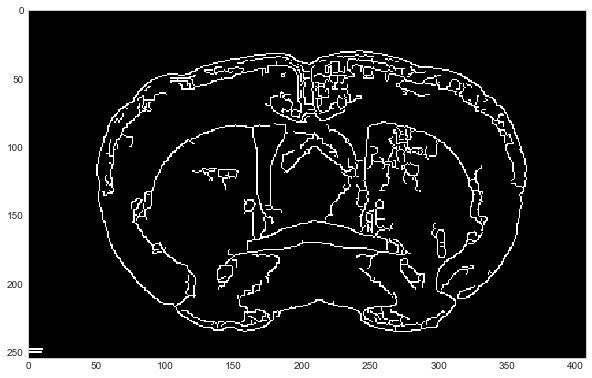

In [188]:
plot_image(edges)

In [189]:
# Upscale the image with edges to original resolution
# edges = cv2.resize(edges,(width, height), interpolation = cv2.INTER_CUBIC)

In [190]:
# plot_image(edges)

In [191]:
# Check fit
# out = edges | img
# plot_image(out)

## Stage 1: Regions of Interest

In [192]:
from skimage.feature import match_template

In [193]:
im2, contours, hierarchy = cv2.findContours(template_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [194]:
template_inv_color = cv2.bitwise_not(template_color)

In [195]:
cnt = contours[4]
cv2.drawContours(template_inv_color, contours, 0, (0,255,0), 5);

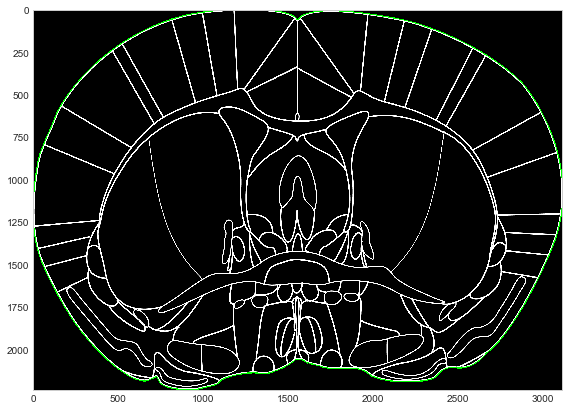

In [196]:
plot_image(template_inv_color, gray=False)

In [197]:
outer_edge = np.zeros_like(template_inv)

In [198]:
cv2.drawContours(outer_edge, contours, 0, (255,255,255), 7);

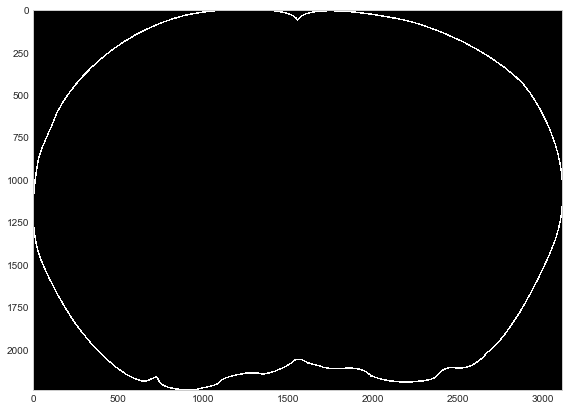

In [199]:
plot_image(outer_edge)

In [211]:
height, width = outer_edge.shape
outer_edge_down = cv2.resize(outer_edge,(int(0.1*width), int(0.1*height)), interpolation = cv2.INTER_AREA)

In [212]:
# Fitting the outer edge
result = match_template(edges, outer_edge_down)

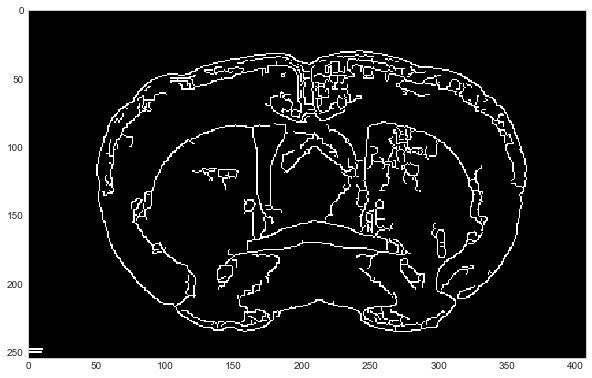

In [213]:
plot_image(edges)

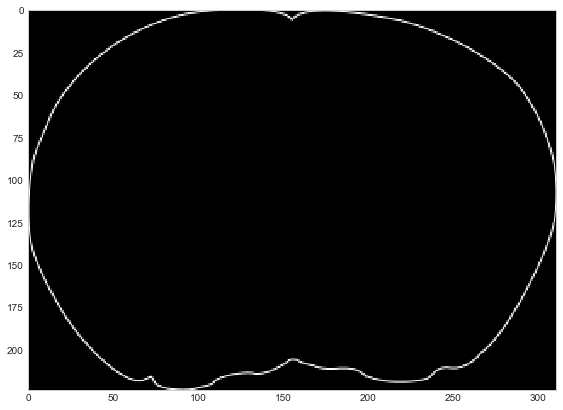

In [214]:
plot_image(outer_edge_down)

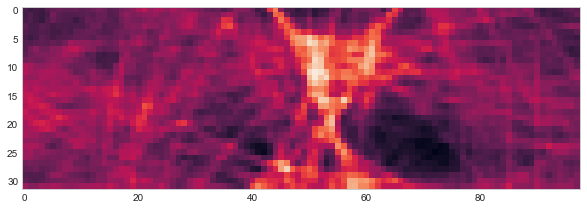

In [216]:
plot_image(result, gray=False)

In [277]:
print('result shape: {}'.format(result.shape))

result shape: (32, 98)


In [278]:
print('template outer edge shape: {}'.format(outer_edge_down.shape))

template outer edge shape: (224, 311)


In [279]:
print('base image outer edge shape: {}'.format(edges.shape))

base image outer edge shape: (255, 408)


In [280]:
# Normalize the result
result_norm = (result - np.mean(result))/np.std(result)

In [281]:
# Find the Region of Interests for Stage 2
_,ROI = cv2.threshold(result_norm,2,255,cv2.THRESH_BINARY)

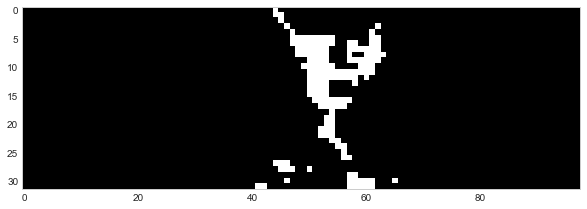

In [282]:
plot_image(ROI)

## Stage 2: Multiresolution Matching

In [347]:
# Find nearest edge pixel
def find_nearest_edge(img, TARGET):
    nonzero = cv2.findNonZero(img)
    distances = (nonzero[:,:,0] - TARGET[0]) ** 2 + (nonzero[:,:,1] - TARGET[1]) ** 2
    nearest_index = np.argmin(distances)
    return nonzero[nearest_index]

# Distance EPF
def distance_epf(img, rho):
    epf = np.zeros((img.shape[0], img.shape[1]))
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            # Check more efficient solution - KD tree?
            coords = find_nearest_edge(img, (x,y))
            epf[y][x] = -np.exp(-rho*((coords[0][0] - x)**2 + (coords[0][1] - y)**2)**0.5)
    return epf

In [354]:
dist_epf = distance_epf(edges, 0.01)

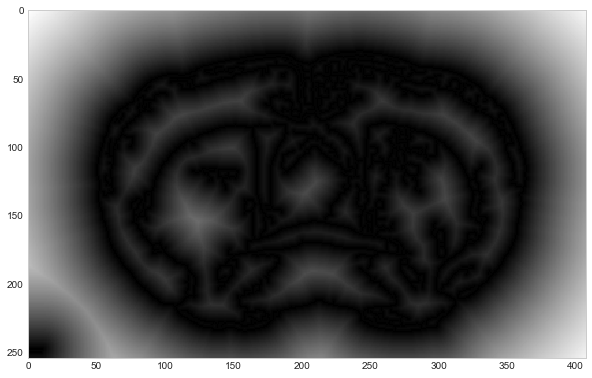

In [355]:
plot_image(dist_epf)